In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

1. Using the raw STRIPS data in the spreadsheet, graph the spot curve and the
3-month forward curve out to the longest maturity of the data (about 25 years).

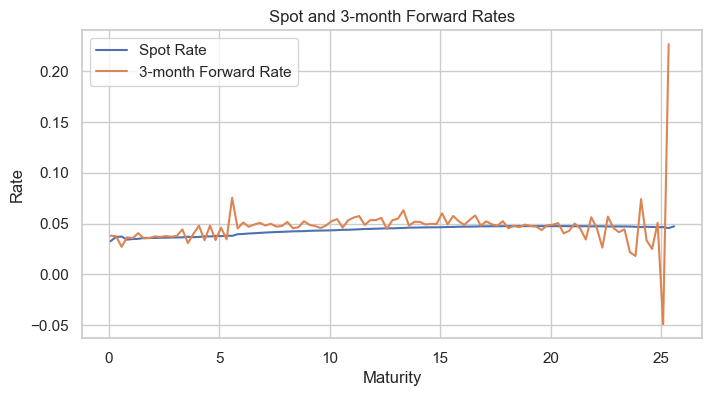

In [2]:
# Upload the data from the 'STRIPS' sheet
strips_df = pd.read_excel("Homework_2_Data.xlsx", sheet_name = "STRIPS")
# Calculate Discount Rate using Spot Rate
strips_df["Discount"] = strips_df['Price']/100
# Create a Spot Rate Column
strips_df["Spot Rate"] = ((1/strips_df["Discount"])**(1/strips_df["Maturity"]/2) - 1)*2
# Calculate 3-month Forward rate using Spot Rate
strips_df["3M Forward"] = (strips_df["Discount"]/strips_df["Discount"].shift(-1)-1)*4

# Plot the results
plt.figure(figsize=(8, 4))

plt.plot(strips_df["Maturity"], strips_df["Spot Rate"], label="Spot Rate")
plt.plot(strips_df["Maturity"][:-1], strips_df["3M Forward"][:-1], label="3-month Forward Rate")

plt.title("Spot and 3-month Forward Rates")
plt.xlabel("Maturity")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()

2. Assume that the discount function can be expressed by the following polynomial
function
$D(T ) = exp(aT + bT^2 + cT^3 + dT^4 + eT^5)$
Using the STRIPS data, estimate the coefficients a, b, c, d, and e by regressing the
log of D(T ) on the indicated powers of T . Do not include an intercept (constant)
term in the regression.

In [3]:
# Create a copy of the Dataframe. Run a log regression. Output the results
X = pd.DataFrame()
X['Maturity'] = strips_df['Maturity']
for i in range(2, 6):
    X[f'Maturity_{i}'] = strips_df['Maturity'] ** i
model = sm.OLS(np.log(strips_df['Discount']), X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:               Discount   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.635e+05
Date:                Wed, 17 Jan 2024   Prob (F-statistic):                   3.01e-220
Time:                        19:46:02   Log-Likelihood:                          430.35
No. Observations:                 103   AIC:                                     -850.7
Df Residuals:                      98   BIC:                                     -837.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

3. Plug the estimated coefficients back into the D(T ) function and graph the resulting spot curve at semiannual frequencies out to 25 years
4. Using the estimated discount function, solve for the par rates at semiannual frequencies out to 25 years. Graph these rates
5. Using the estimated discount function, solve for the 6-month forward rates at semiannual frequencies out to 25 years. Graph these rates.

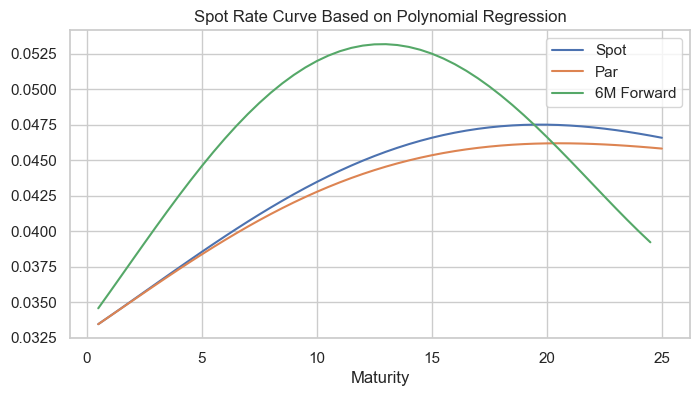

In [4]:
df = pd.DataFrame(np.arange(0.5, 25.5, 0.5),columns=['Maturity'])
for i in range(2, 6):
    df[f'Maturity_{i}'] = df['Maturity'] ** i

strips_df_semi = pd.DataFrame(np.arange(0.5, 25.5, 0.5),columns=['Maturity'])
strips_df_semi['Discount'] = np.exp(model.predict(df))
strips_df_semi['Spot Rate'] = ((1/strips_df_semi["Discount"])**(1/strips_df_semi["Maturity"]/2) - 1)*2
strips_df_semi['Discount cums'] = strips_df_semi['Discount'].cumsum()
strips_df_semi['Par Rate'] = 2*(1-strips_df_semi['Discount'])/strips_df_semi['Discount cums']
strips_df_semi['6M Forward'] = (strips_df_semi["Discount"]/strips_df_semi["Discount"].shift(-1)-1)*2

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(strips_df_semi['Maturity'], strips_df_semi['Spot Rate'], label='Spot')
plt.plot(strips_df_semi['Maturity'], strips_df_semi['Par Rate'], label='Par')
plt.plot(strips_df_semi['Maturity'], strips_df_semi['6M Forward'], label='6M Forward')

plt.title("Spot Rate Curve Based on Polynomial Regression")
plt.xlabel("Maturity")
plt.legend()
plt.show()

6. Assume that the par curve for maturity T is given by the following function
$Y(T) = a + bT + cT^2 + dT^3 + eT^4 + fT^5$ <br>
Using the Treasury note and bond data, bootstrap the spot curve. To make things
easier, you can assume that each of the bonds is priced at par.
From this bootstrapped curve, graph the resulting spot curve, par curve, and 6
month forward curve out to 25 years.

In [5]:
T_note_df = pd.read_excel("Homework_2_Data.xlsx", sheet_name = "T-Note")
X = pd.DataFrame()
X['Maturity'] = T_note_df['Maturity']
for i in range(2, 6):
    X[f'Maturity_{i}'] = T_note_df['Maturity'] ** i
X['Constant'] = 1
model2 = sm.OLS(T_note_df['Yield']/100, X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1199.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):           8.18e-62
Time:                        19:46:03   Log-Likelihood:                 427.14
No. Observations:                  70   AIC:                            -842.3
Df Residuals:                      64   BIC:                            -828.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Maturity       0.0051      0.000     17.951      0.0

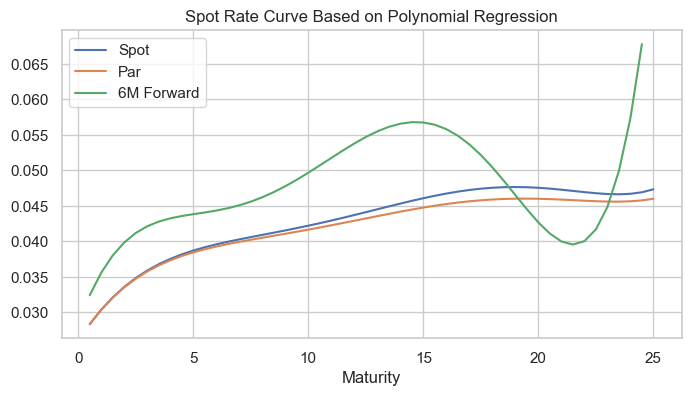

In [6]:
df = pd.DataFrame(np.arange(0.5, 25.5, 0.5),columns=['Maturity'])
for i in range(2, 6):
    df[f'Maturity_{i}'] = df['Maturity'] ** i
df['Constant'] = 1
T_note_df_semi = pd.DataFrame(np.arange(0.5, 25.5, 0.5),columns=['Maturity'])
T_note_df_semi['Yield'] = model2.predict(df)

# bootstrapping
discount = []
for index, row in T_note_df_semi.iterrows():
    y = row['Yield']
    if index == 0:
        d = 1/(1+y/2)
    else:
        d = (1-y/2*sum(discount))/(1+y/2)
    discount.append(d)

T_note_df_semi['Discount'] = discount
T_note_df_semi['Spot Rate'] = ((1/T_note_df_semi["Discount"])**(1/T_note_df_semi["Maturity"]/2) - 1)*2
T_note_df_semi['Discount cums'] = T_note_df_semi['Discount'].cumsum()
T_note_df_semi['Par Rate'] = 2*(1-T_note_df_semi['Discount'])/T_note_df_semi['Discount cums']
T_note_df_semi['6M Forward'] = (T_note_df_semi["Discount"]/T_note_df_semi["Discount"].shift(-1)-1)*2

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(T_note_df_semi['Maturity'], T_note_df_semi['Spot Rate'], label='Spot')
plt.plot(T_note_df_semi['Maturity'], T_note_df_semi['Par Rate'], label='Par')
plt.plot(T_note_df_semi['Maturity'], T_note_df_semi['6M Forward'], label='6M Forward')

plt.title("Spot Rate Curve Based on Polynomial Regression")
plt.xlabel("Maturity")
plt.legend()
plt.show()

7. Compare the spot, par, and forward curves from fitting the STRIPS curve with those from fitting the par curve. What do you attribute the difference to?

Answer: Differences between the STRIPS curve and the par curve can be attributed to the fact that STRIPS focus on zero-coupon bonds, while the par curve considers bonds with periodic coupon payments. The presence of coupon payments in the par curve introduces factors such as reinvestment risk, which can lead to variations in yield curves, especially at longer maturities. Additionally, market expectations and sentiment can influence the forward rates derived from both curves.